Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit




Load the dataset

In [2]:
orbits_df = pd.read_csv("orbits.csv")

<ipython-input-2-e95418f13956>:1: DtypeWarning: Columns (7,8,9,10,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  orbits_df = pd.read_csv("orbits.csv")


Take a Quick Look at the Data Structure

In [3]:
orbits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048121 entries, 0 to 1048120
Data columns (total 35 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   NEO_flag          24586 non-null    float64
 1   One_km_NEO_flag   1407 non-null     float64
 2   PHA_flag          2163 non-null     float64
 3   H                 1046851 non-null  float64
 4   G                 1046851 non-null  float64
 5   Num_obs           1048114 non-null  float64
 6   rms               1048062 non-null  float64
 7   U                 1006441 non-null  object 
 8   Arc_years         952529 non-null   object 
 9   Perturbers        1002642 non-null  object 
 10  Perturbers_2      1002642 non-null  object 
 11  Number            546846 non-null   object 
 12  Name              22153 non-null    object 
 13  Principal_desig   1048121 non-null  object 
 14  Other_desigs      74966 non-null    object 
 15  Epoch             1048121 non-null  float64
 16  

Plot correlation  matrix of all numerical features with the labels(one hot encoded) to find the ones with high correlation

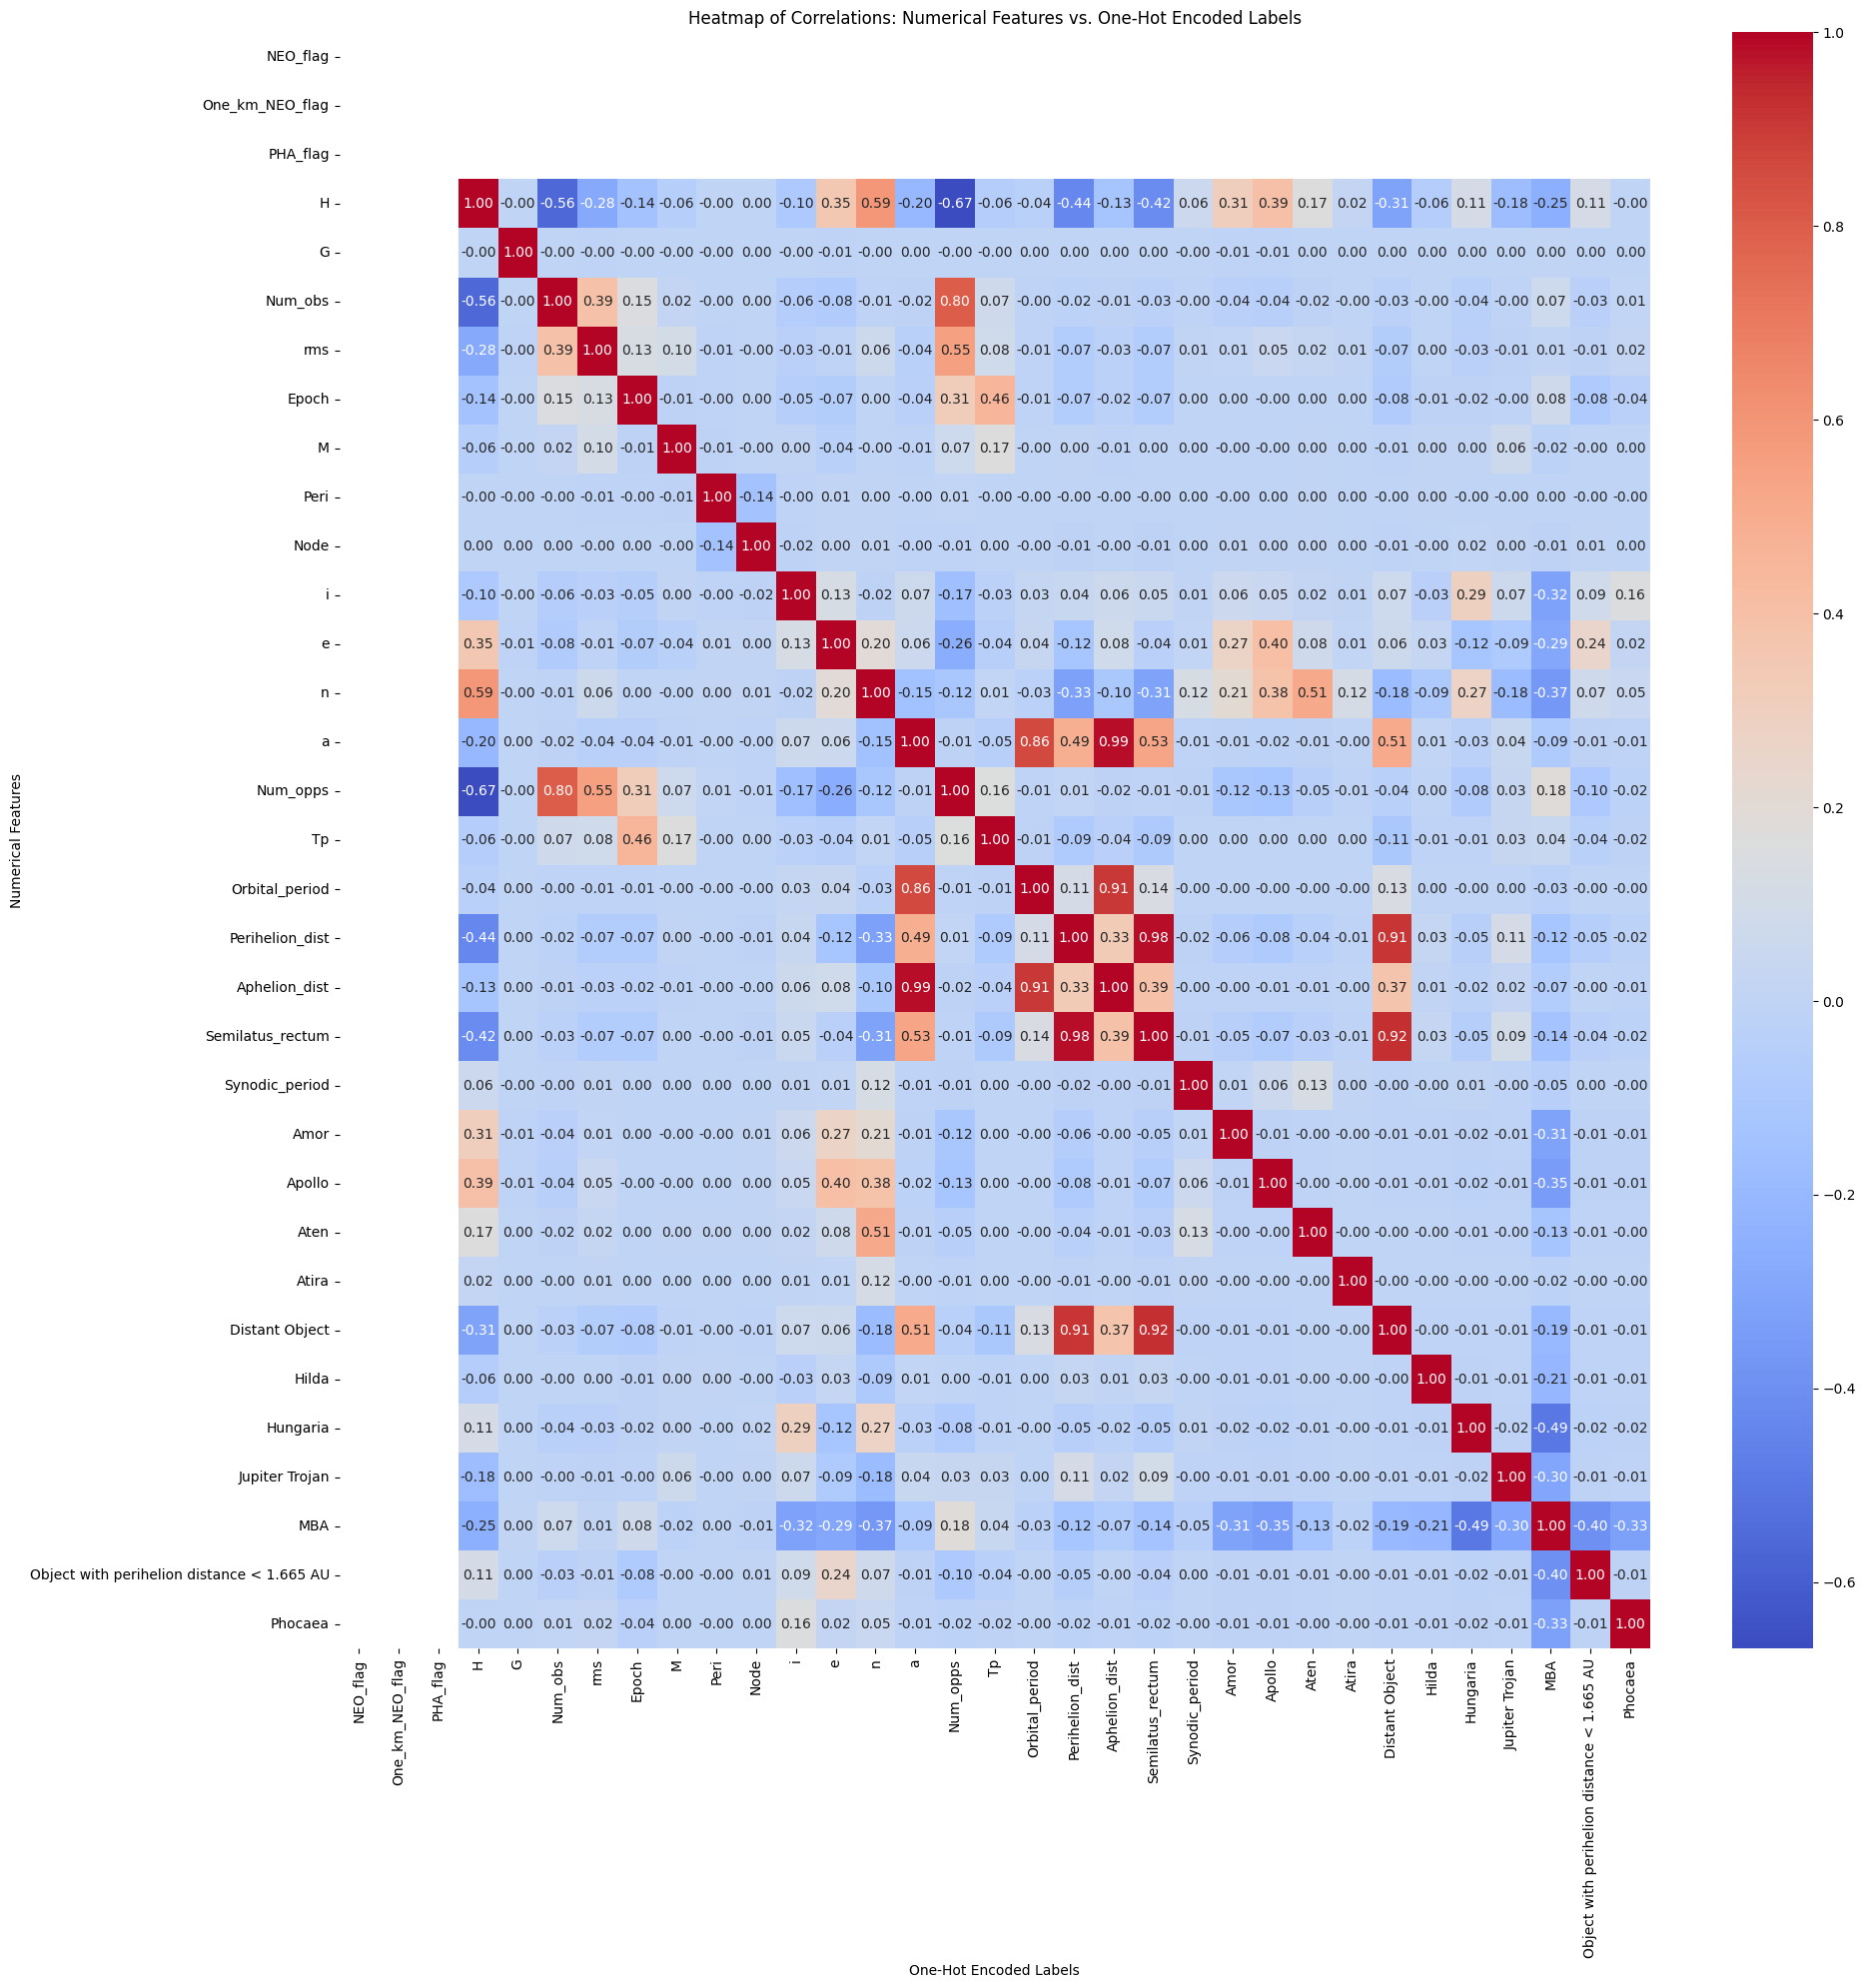

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select only numeric columns
numeric_df = orbits_df.select_dtypes(include=['number'])

# Step 2: One-hot encode 'Orbit_type'
encoded_labels_df = pd.get_dummies(orbits_df, columns=['Orbit_type'], drop_first=False)

encoded_labels_df = pd.get_dummies(orbits_df['Orbit_type'], drop_first=False)

# Step 3: Concatenate the encoded labels with numeric data
combined_df = pd.concat([numeric_df, encoded_labels_df], axis=1)

# Step 4: Compute correlation between numerical features and one-hot encoded labels
correlation_results_df = combined_df.corr()
# Step 4: Plot the heatmap
plt.figure(figsize=(20, 20))  # Adjust the size for better readability
sns.heatmap(correlation_results_df, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("Heatmap of Correlations: Numerical Features vs. One-Hot Encoded Labels")
plt.ylabel("Numerical Features")
plt.xlabel("One-Hot Encoded Labels")
plt.tight_layout()
plt.show()

Identify catagorical features


In [ ]:
cat_df = orbits_df.select_dtypes(include=['object'])
cat_df.head()

,U,Arc_years,Perturbers,Perturbers_2,Number,Name,Principal_desig,Other_desigs,Ref,Computer,Hex_flags,Last_obs,Orbit_type
0,0,1801-2020,M-v,30k,(1),Ceres,A801 AA,"['A899 OF', '1943 XB']",E2021-B10,Pan,0000,2020-11-18,MBA
1,0,1804-2020,M-c,28k,(2),Pallas,A802 FA,NaN,E2021-B10,Pan,0000,2020-11-05,MBA
2,0,1804-2020,M-v,3Ek,(3),Juno,A804 RA,NaN,E2021-B10,Pan,0000,2020-09-12,MBA
3,0,1821-2020,M-p,18k,(4),Vesta,A807 FA,NaN,E2021-B10,Pan,0000,2020-12-16,MBA
4,0,1845-2020,M-v,3Ek,(5),Astraea,A845 XA,['1969 SE'],E2021-B10,Pan,0000,2020-06-19,MBA


Drop irrelevant features


In [5]:
orbits_df = orbits_df.drop(columns=['PHA_flag','Tp','i' ,'G','Number','U','Name','Other_desigs','Epoch','M', 'Peri', 'Node','Perturbers','Principal_desig','Ref','Arc_years','Computer' ,'Orbital_period','Num_opps','NEO_flag','rms','One_km_NEO_flag'])

In [6]:
orbits_df["Orbit_type"].value_counts()

,count
Orbit_type,
MBA,951452
Hungaria,25449
Object with perihelion distance < 1.665 AU,16810
Apollo,12610
Phocaea,11400
Amor,10373
Jupiter Trojan,9423
Hilda,4643
Distant Object,4026


Remove duplicate instances

In [7]:
def remove_duplicate_rows(dataframe):
    """
    Remove duplicate rows from a DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame to clean.

    Returns:
        pd.DataFrame: A cleaned DataFrame with duplicate rows removed.
    """
    return dataframe.drop_duplicates()
orbits_df=remove_duplicate_rows(orbits_df)

Undersample MBA class

In [8]:
def sample_classes(df, class_column, class_to_keep, sample_size):
    """
    Keep a limited number of rows for a specified class in a DataFrame, and keep all other rows from other classes.

    Parameters:
    - df: pandas DataFrame, the dataset.
    - class_column: str, name of the column containing class labels.
    - class_to_keep: str, the class label to keep.
    - sample_size: int, number of rows to keep for the specified class.

    Returns:
    - A DataFrame containing the specified class with the limited number of instances and all other classes.
    """
    # Filter for the class to keep
    class_subset = df[df[class_column] == class_to_keep]

    # Sample the specified number of rows from this class
    sampled_subset = class_subset.sample(n=sample_size, random_state=42, replace=False)

    # Filter for the other classes (excluding the class_to_keep)
    other_classes_subset = df[df[class_column] != class_to_keep]

    # Combine the sampled subset of the specified class with the other classes
    final_df = pd.concat([sampled_subset, other_classes_subset], axis=0).reset_index(drop=True)

    return final_df

# Call the function for the 'MBA' class
orbits_df = sample_classes(orbits_df, 'Orbit_type', 'MBA', 25449)


In [ ]:
orbits_df["Orbit_type"].value_counts()

,count
Orbit_type,
MBA,25449
Hungaria,25449
Object with perihelion distance < 1.665 AU,16810
Apollo,12610
Phocaea,11400
Amor,10373
Jupiter Trojan,9423
Hilda,4643
Distant Object,4026


Drop instances with nulls

In [10]:
orbits_df.dropna(how='all',inplace=True)

Convert a numerical feature which currently has string datatype to a numerical type

In [9]:
def convert_to_numeric(value):
    if isinstance(value, float):
        return value
    value = value.strip().lower()  # Remove whitespace and convert to lowercase
    if 'e' in value:
        num_part = float(value.replace('e', '').replace('k', '').replace('h', '').strip())
        return num_part * (10 ** 18)  # Exa
    elif 'k' in value:
        return float(value.replace('k', '').replace('h', '').strip()) * 1000  # Thousand
    elif 'h' in value:
        return float(value.replace('h', '').strip()) * 100  # Hundred
    else:
        return float(value)  # No suffix, return as is
orbits_df['Perturbers_2'] = orbits_df['Perturbers_2'].apply(convert_to_numeric)

 Split data set for training and testing

In [11]:
# Separate numeric and non-numeric columns
numeric_cols = orbits_df.select_dtypes(include=['number']).columns
non_numeric_cols = orbits_df.select_dtypes(exclude=['number']).columns

# Fill missing values in numeric columns with the median
orbits_df[numeric_cols] = orbits_df[numeric_cols].fillna(orbits_df[numeric_cols].median())

# Fill missing values in non-numeric columns with the mode
for col in non_numeric_cols:
    orbits_df[col] = orbits_df[col].fillna(orbits_df[col].mode()[0])



# Split the data into features (X) and target (y)
X = orbits_df.drop(columns=['Orbit_type'])  # Features
y = orbits_df['Orbit_type']  # Target variable

# Perform stratified splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Combine train and test sets for analysis
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)



orbits=> before data processing


In [12]:
orbits=orbits_df.copy()

Remove outliers based on each class

In [13]:
import pandas as pd

def remove_outliers_by_orbit(df, columns, orbit_column):
    """
    Calculates the mean for each orbit type and removes outliers using the IQR method.

    Parameters:
    - df: pandas DataFrame.
    - columns: List of numerical columns to check for outliers.
    - orbit_column: The column representing the orbit types.

    Returns:
    - DataFrame with outliers removed.
    """
    filtered_dfs = []

    # Iterate over each orbit type
    for orbit_type in df[orbit_column].unique():
        orbit_subset = df[df[orbit_column] == orbit_type]

        # Print mean values for debugging
        orbit_means = orbit_subset[columns].mean()

        # Remove outliers for numerical columns
        for col in columns:
            Q1 = orbit_subset[col].quantile(0.25)  # First quartile
            Q3 = orbit_subset[col].quantile(0.75)  # Third quartile
            IQR = Q3 - Q1                          # Interquartile range
            lower_bound = Q1 - 1.5 * IQR           # Lower bound
            upper_bound = Q3 + 1.5 * IQR           # Upper bound

            # Keep only rows within the bounds
            orbit_subset = orbit_subset[(orbit_subset[col] >= lower_bound) & (orbit_subset[col] <= upper_bound)]

        # Add the filtered subset to the list
        filtered_dfs.append(orbit_subset)

    # Combine and reset index
    return pd.concat(filtered_dfs, axis=0).reset_index(drop=True)


In [14]:
numerical_cols = orbits_df.select_dtypes(include=['number']).columns
train=remove_outliers_by_orbit(train, numerical_cols, 'Orbit_type')


Oversample Atira class in training data

In [15]:

def oversample_and_add(df, class_column, class_to_oversample, sample_size):
    """
    Oversample a specified orbit type, add the oversampled instances to the original DataFrame,
    and return the updated DataFrame.

    Parameters:
    - df: pandas DataFrame, the dataset.
    - class_column: str, name of the column containing class labels.
    - class_to_oversample: str, the orbit type label to oversample.
    - sample_size: int, number of rows to create for the oversampled orbit type.

    Returns:
    - Updated DataFrame with oversampled instances added.
    """
    # Filter the DataFrame to get the subset of the class to oversample
    class_subset = df[df[class_column] == class_to_oversample]

    oversampled_subset = class_subset.sample(n=sample_size, replace=True, random_state=42)

    # Add the oversampled subset back to the original DataFrame
    updated_df = pd.concat([df, oversampled_subset], axis=0).reset_index(drop=True)

    return updated_df

# Example usage to oversample the "Atria" orbit type and add the oversampled instances to the original DataFrame
train = oversample_and_add(train, 'Orbit_type', 'Atira', 100)


replace na with median and mode for catgorical#  


In [16]:

for col in train.columns:
    if train[col].dtype == 'object':  # For categorical columns
        train[col] = train[col].fillna(train[col].mode().iloc[0])
    else:  # For numerical columns
        train[col] = train[col].fillna(orbits[col].median())

for col in test.columns:
    if test[col].dtype == 'object':  # For categorical columns
        test[col] = test[col].fillna(train[col].mode().iloc[0])
    else:  # For numerical columns
        test[col] = test[col].fillna(orbits[col].median())



In [ ]:
train['Orbit_type'].value_counts()

,count
Orbit_type,
Hungaria,15201
MBA,13451
Object with perihelion distance < 1.665 AU,9511
Apollo,7502
Amor,6794
Phocaea,6357
Jupiter Trojan,6228
Hilda,2374
Distant Object,1777


Logarithmic transformation for highly skewed features

In [17]:
# Identify skewed numerical features

numerical_cols = train.select_dtypes(include=['number']).columns.difference(['H']).tolist()

skewed_features = train[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness of Numerical Features:")
print(skewed_features)

# Select features with high skewness (e.g., skewness > 1 or <-1)
high_skew_features_train = skewed_features[skewed_features.abs() > 1].index
print("\nHighly Skewed Features:")
print(high_skew_features_train)


# Identify skewed numerical features

numerical_cols = test.select_dtypes(include=['number']).columns.difference(['H']).tolist()

skewed_features = test[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print("Skewness of Numerical Features:")
print(skewed_features)

# Select features with high skewness (e.g., skewness > 1 or <-1)
high_skew_features_test= skewed_features[skewed_features.abs() > 1].index
print("\nHighly Skewed Features:")
print(high_skew_features_test)

Skewness of Numerical Features:
Synodic_period      11.469385
Aphelion_dist        5.896068
Perihelion_dist      5.881228
a                    5.864916
Semilatus_rectum     5.847023
n                    2.514916
Num_obs              2.480297
Perturbers_2         1.498812
e                    1.008001
dtype: float64

Highly Skewed Features:
Index(['Synodic_period', 'Aphelion_dist', 'Perihelion_dist', 'a',
       'Semilatus_rectum', 'n', 'Num_obs', 'Perturbers_2', 'e'],
      dtype='object')
Skewness of Numerical Features:
Synodic_period      55.588009
Aphelion_dist       48.230683
a                   38.433653
Semilatus_rectum     5.959585
Perihelion_dist      5.633121
Num_obs              4.970778
n                    2.411012
e                    1.229935
Perturbers_2         0.629274
dtype: float64

Highly Skewed Features:
Index(['Synodic_period', 'Aphelion_dist', 'a', 'Semilatus_rectum',
       'Perihelion_dist', 'Num_obs', 'n', 'e'],
      dtype='object')


In [18]:
for col in high_skew_features_train:
    train[col] = np.log1p(orbits_df[col])

for col in high_skew_features_test:
    test[col] = np.log1p(orbits_df[col])


Option 1: MinMac Scaling (Not recommended = PCA)

In [ ]:
# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Fit and transform the numerical columns
# orbits_df[numerical_cols] = scaler.fit_transform(orbits_df[numerical_cols])

Option 2: Standard Scaling (Recommended = PCA)

In [19]:
numerical_cols_train= train.select_dtypes(include=['number']).columns

numerical_cols_test= test.select_dtypes(include=['number']).columns


In [20]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the numerical columns
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.fit_transform(test[numerical_cols])

**Visulaise data before and after removing outliers and logrithmic scaling*

Before outlier handling:

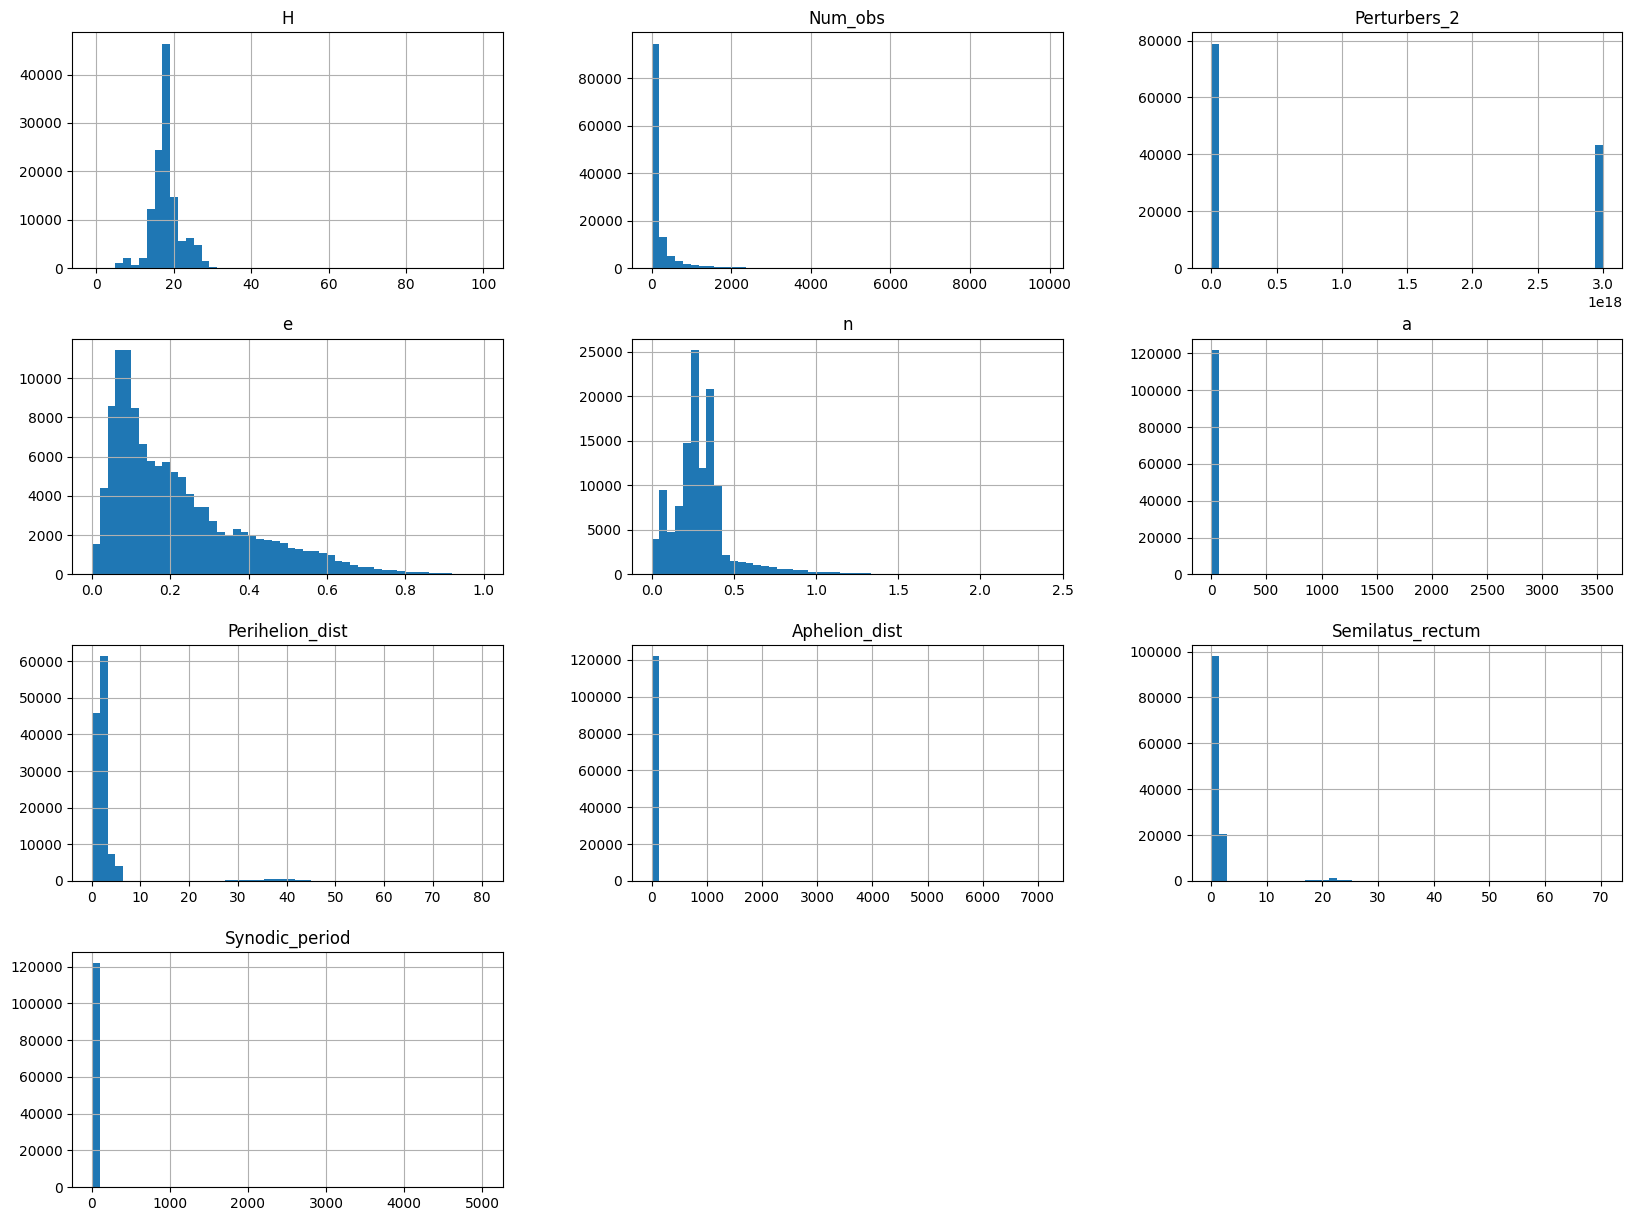

In [21]:
numerical_cols = orbits.select_dtypes(include=['number']).columns
%matplotlib inline
import matplotlib.pyplot as plt
orbits[numerical_cols].hist(bins=50, figsize=(20,15))
plt.show()

Histograms after scaling:

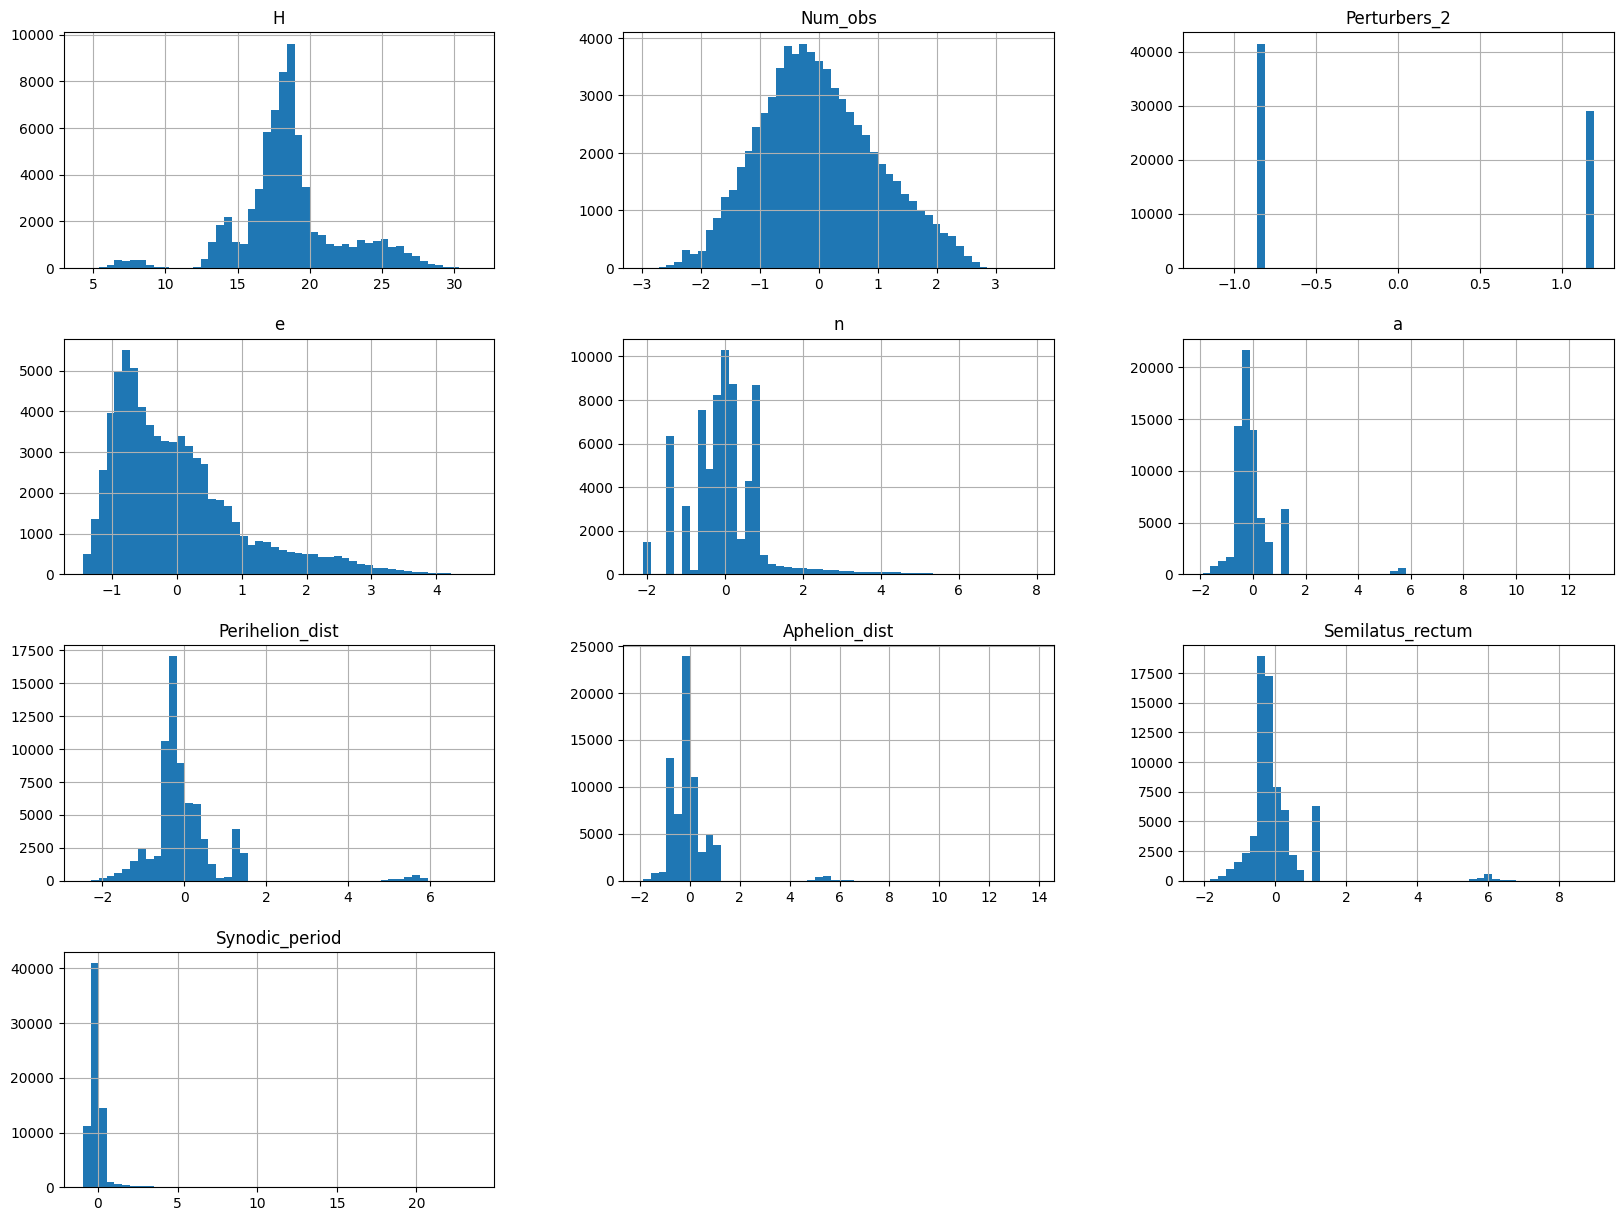

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
train[numerical_cols].hist(bins=50, figsize=(20,15))
plt.show()

**Box plots for all numerical features**

Before outlier handling:

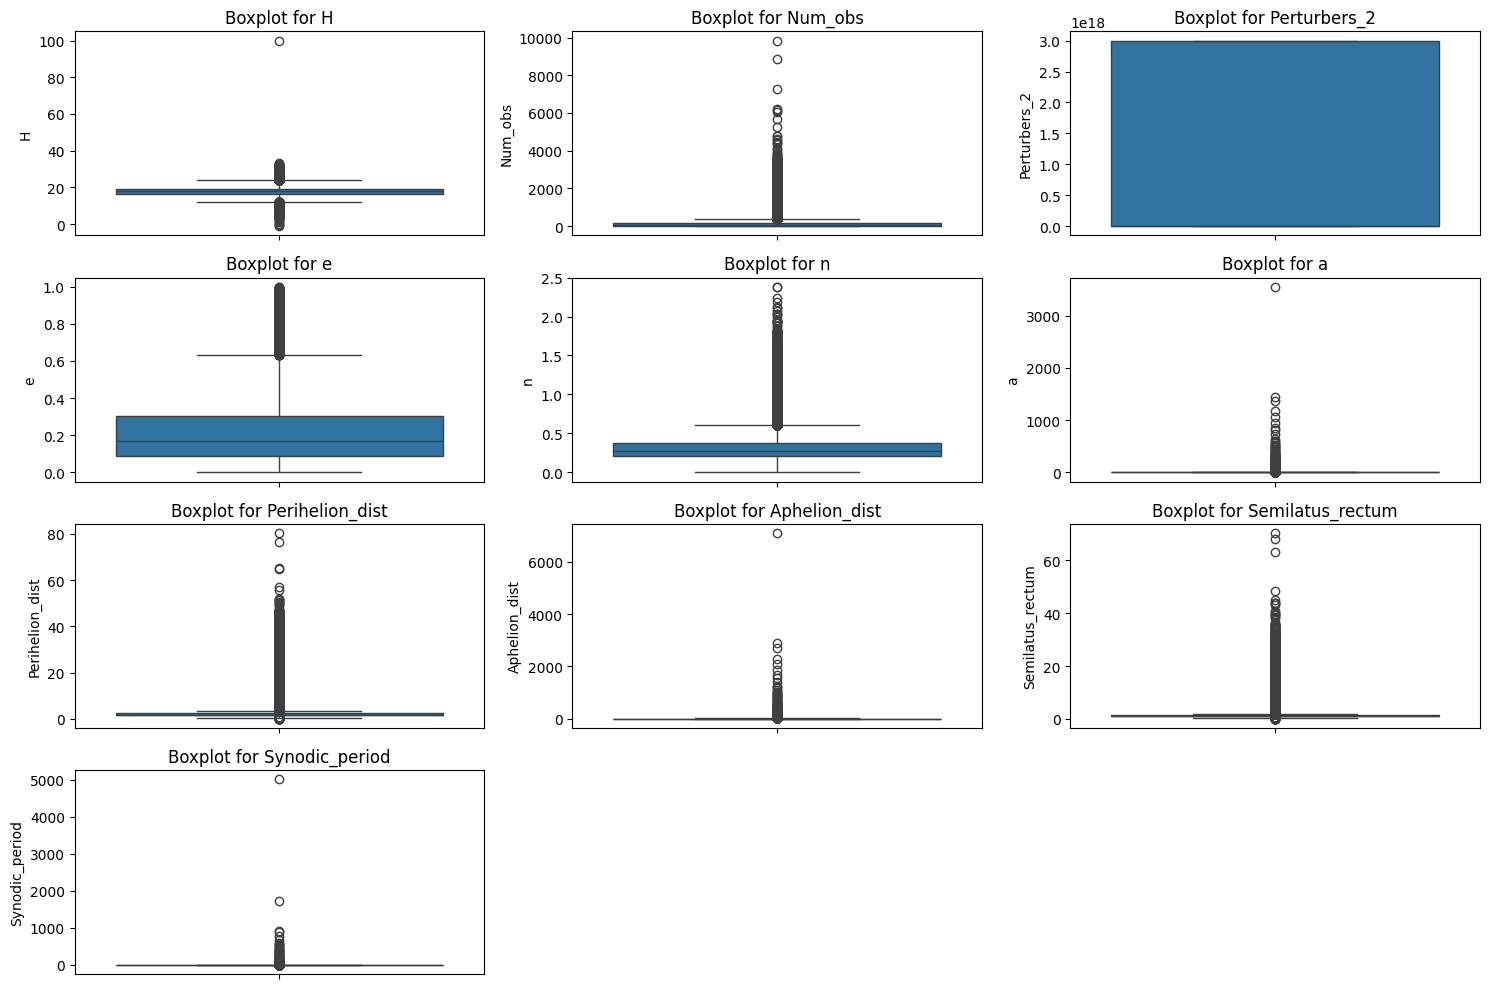

In [23]:
# Box plots for numerical features
plt.figure(figsize=(15, 10))
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, idx)
    sns.boxplot(y=orbits[col])
    plt.title(f"Boxplot for {col}")
plt.tight_layout()
plt.show()

After outlier handling:

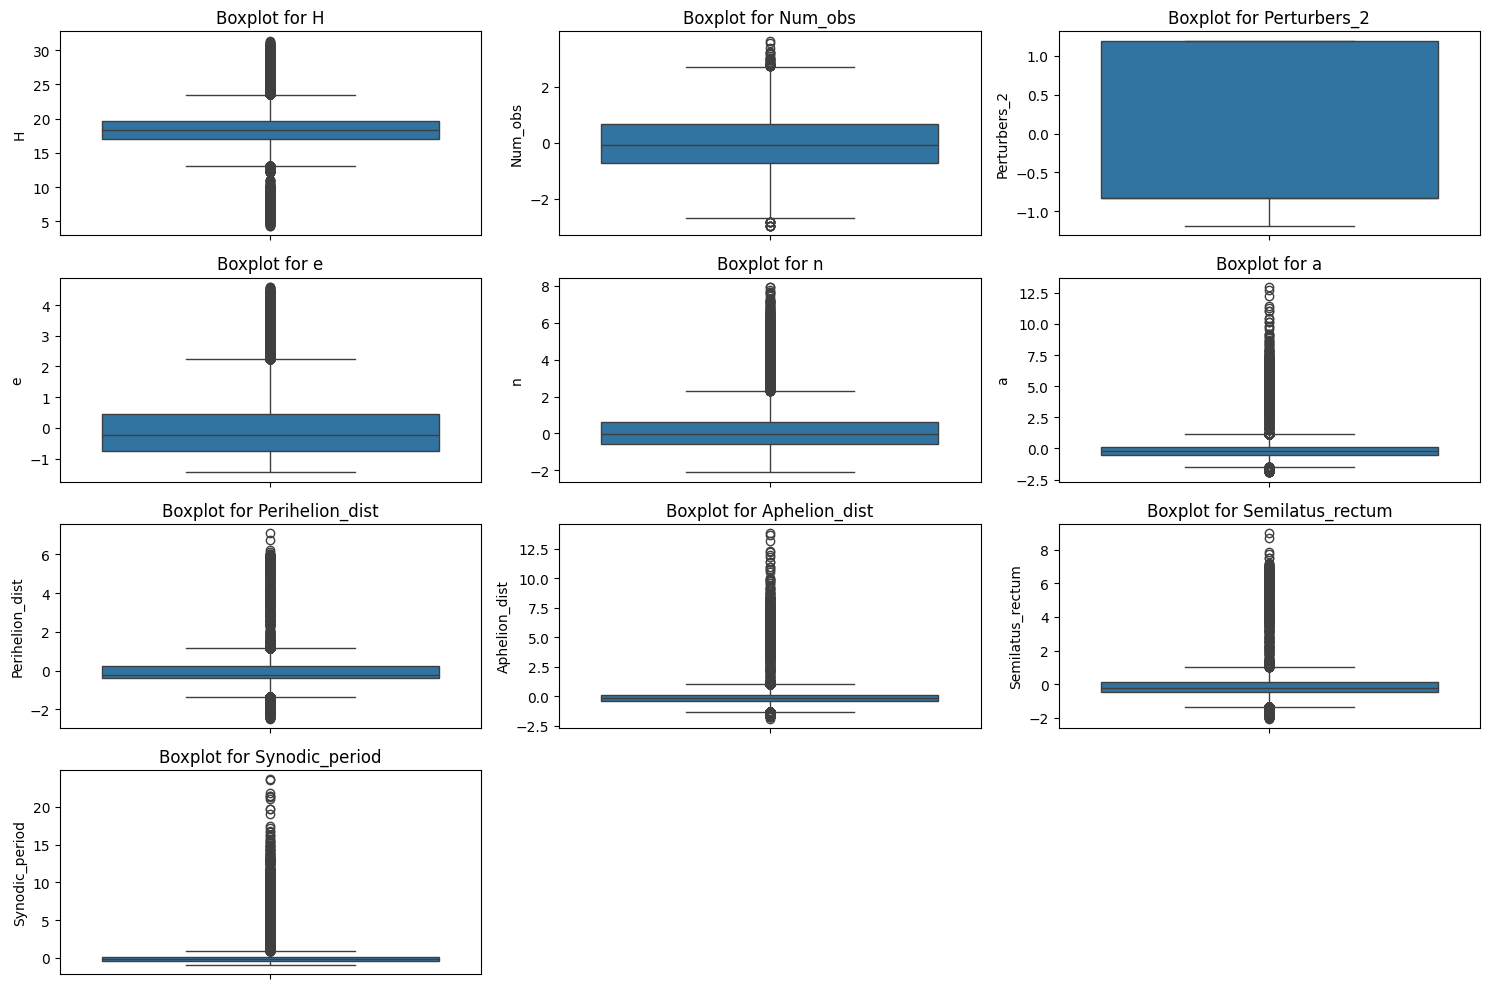

In [24]:
# Box plots for numerical features
plt.figure(figsize=(15, 10))
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, idx)
    sns.boxplot(y=train[col])
    plt.title(f"Boxplot for {col}")
plt.tight_layout()
plt.show()

Compute correlation matrix for numerical features with each other

before preprocessing

In [25]:
# Compute correlation matrix for numerical features
numerical_correlation_matrix = orbits[numerical_cols].corr()

# Extract the upper triangle of the correlation matrix to avoid redundancy
upper_triangle = numerical_correlation_matrix.where(
    np.triu(np.ones(numerical_correlation_matrix.shape), k=1).astype(bool)
)

# Flatten the matrix and sort correlations in descending order
correlation_pairs = (
    upper_triangle.unstack()
    .dropna()
    .sort_values(ascending=False)
)

# Display the sorted correlations between features


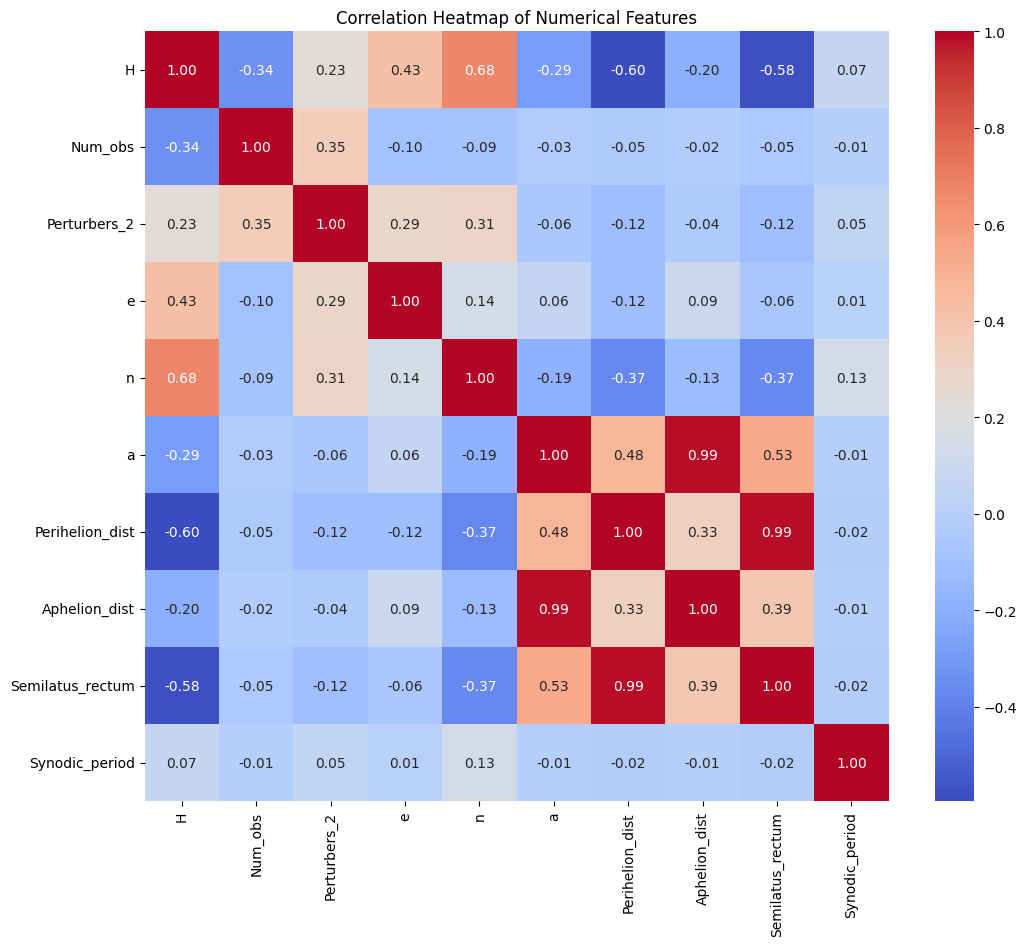

In [26]:
# Compute and plot correlation heatmap
correlation_matrix = orbits[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

After preproccessing


In [27]:
# Compute correlation matrix for numerical features
numerical_correlation_matrix = train[numerical_cols].corr()

# Extract the upper triangle of the correlation matrix to avoid redundancy
upper_triangle = numerical_correlation_matrix.where(
    np.triu(np.ones(numerical_correlation_matrix.shape), k=1).astype(bool)
)

# Flatten the matrix and sort correlations in descending order
correlation_pairs = (
    upper_triangle.unstack()
    .dropna()
    .sort_values(ascending=False)
)

# Display the sorted correlations between features


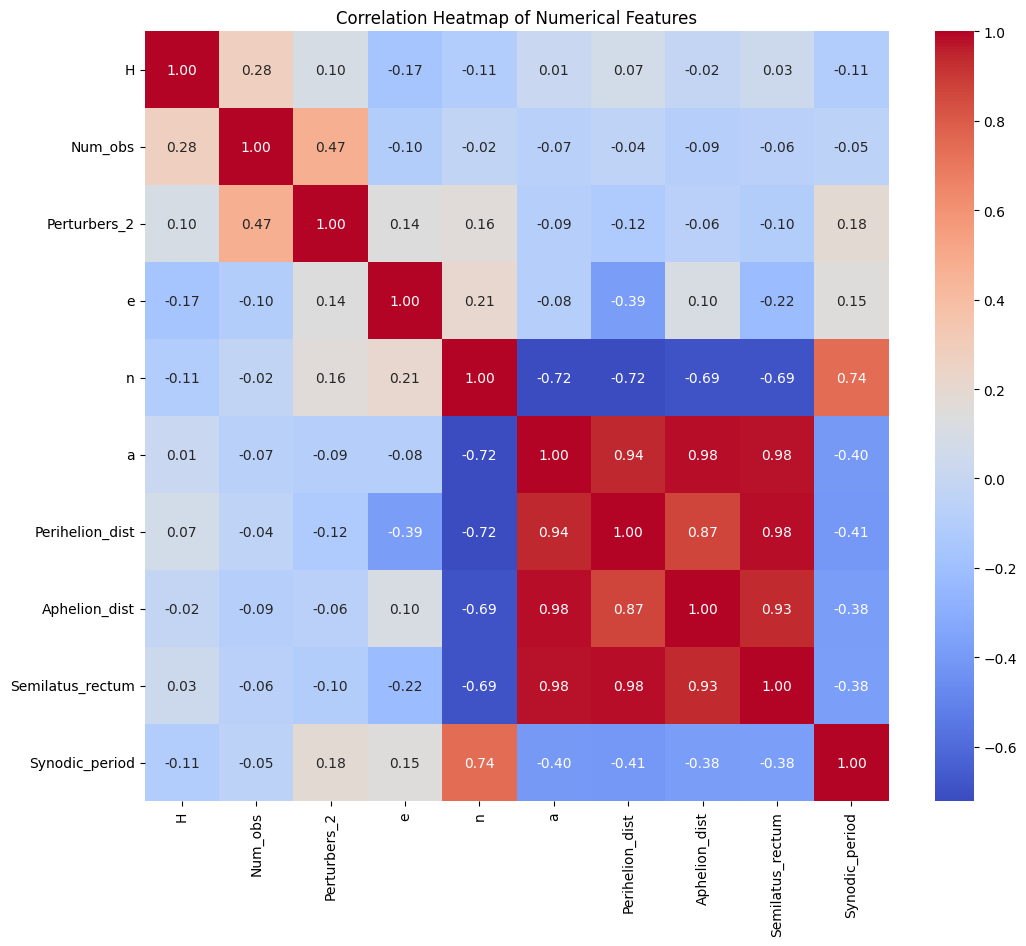

In [28]:
# Compute and plot correlation heatmap
correlation_matrix = train[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

DON'T TAKES TOO LONG:

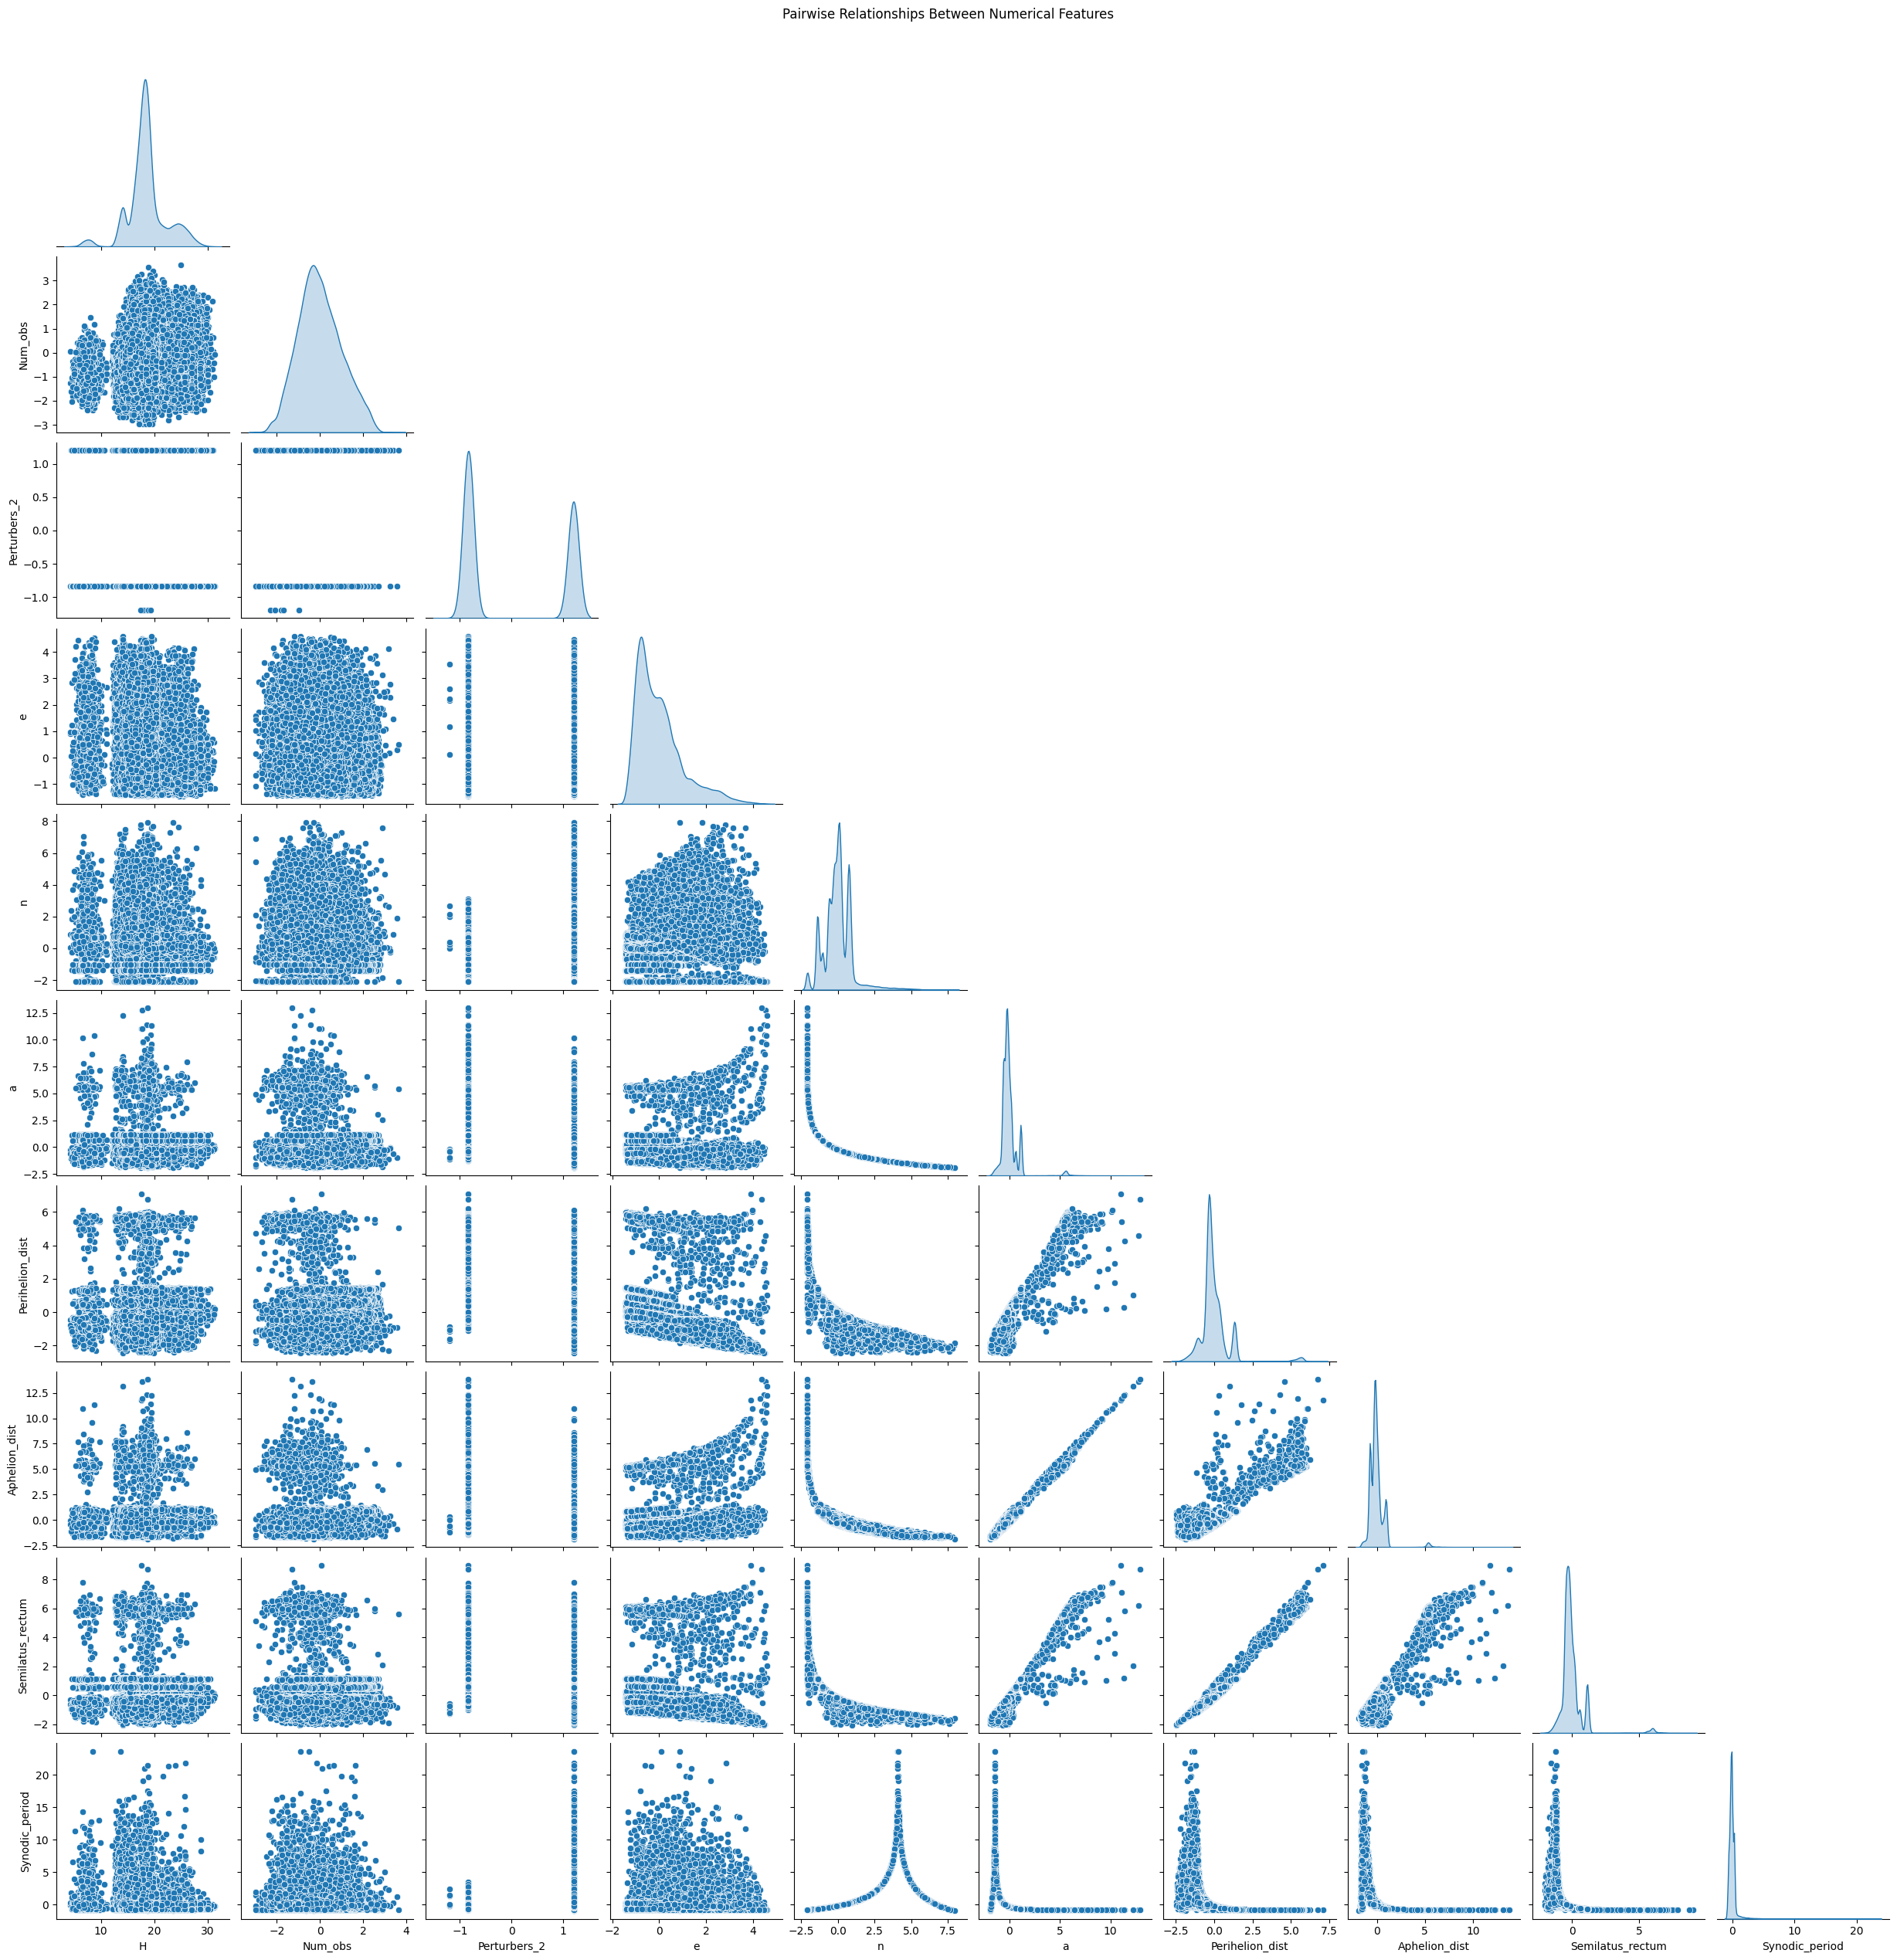

In [29]:
# Plot pairwise relationships for numerical features
sns.pairplot(train[numerical_cols], diag_kind='kde', corner=True)
plt.suptitle("Pairwise Relationships Between Numerical Features", y=1.02)
plt.show()

==End of comparison==

Compute correlation between each numerical feature and each one-hot encoded label

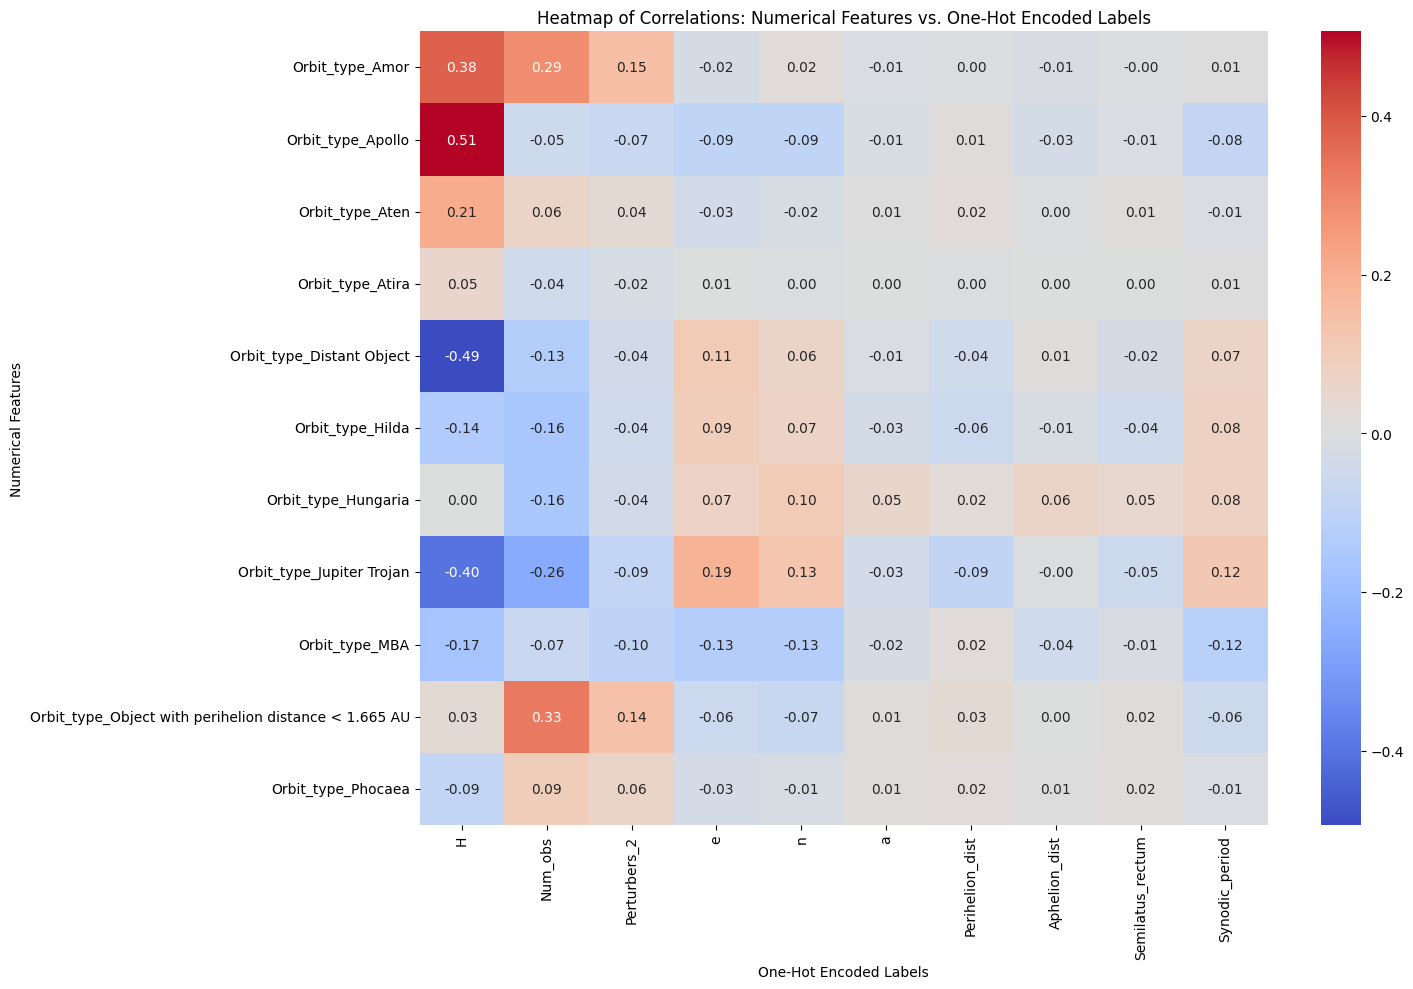

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation between each numerical feature and each one-hot encoded label
numeric_df = train.select_dtypes(include=['number']).columns
encoded_labels_df = pd.get_dummies(train, columns=['Orbit_type'], drop_first=False)

# Initialize a dictionary to store correlation results
correlation_results = {}


# Calculate correlation for each numerical feature with each one-hot encoded label
for num_col in numeric_df:
    correlation_results[num_col] = {}
    for label_col in [col for col in encoded_labels_df.columns if col.startswith('Orbit_type_')]:
        # Compute correlation and store it
        correlation = encoded_labels_df[num_col].corr(encoded_labels_df[label_col])
        correlation_results[num_col][label_col] = correlation

# Convert correlation results to a DataFrame
correlation_results_df = pd.DataFrame(correlation_results).transpose()
correlation_results_df=correlation_results_df.transpose()
# Plot a heatmap for better visualization
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_results_df, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("Heatmap of Correlations: Numerical Features vs. One-Hot Encoded Labels")
plt.ylabel("Numerical Features")
plt.xlabel("One-Hot Encoded Labels")
plt.tight_layout()
plt.show()



Perform svd( isnt applied)

Optimal number of components to retain 95.0% variance: 1


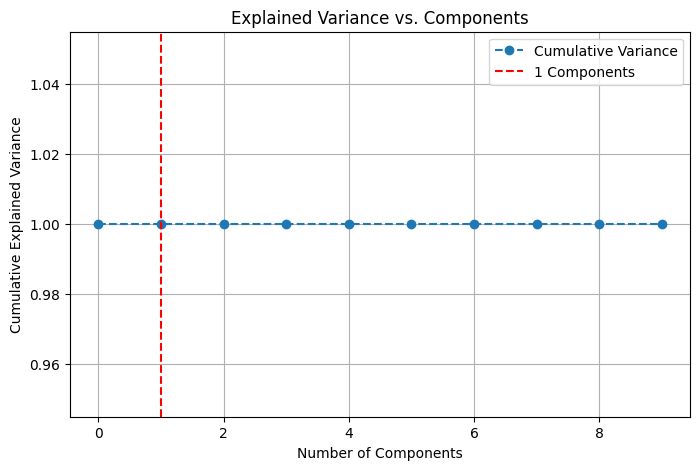

            PC1
0  3.000000e+18
1  3.000000e+18
2  3.000000e+18
3  3.000000e+18
4  3.800000e+03


In [31]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Desired explained variance threshold
desired_variance = 0.95

# Select numeric columns for SVD
orbits_df_numeric = orbits_df.select_dtypes(include=[np.number])

# Step 1: Initial TruncatedSVD with a large number of components
# Use the smaller dimension of the data as the initial number of components
initial_components = min(orbits_df_numeric.shape[0], orbits_df_numeric.shape[1])
svd = TruncatedSVD(n_components=initial_components)
svd.fit(orbits_df_numeric)

# Step 2: Calculate cumulative explained variance
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Step 3: Find the optimal number of components to retain desired variance
optimal_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f"Optimal number of components to retain {desired_variance*100}% variance: {optimal_components}")

# Optional: Visualize the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Variance')
plt.axvline(x=optimal_components, color='red', linestyle='--', label=f'{optimal_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Components')
plt.legend()
plt.grid()
plt.show()

# Step 4: Apply TruncatedSVD with optimal number of components
svd_optimal = TruncatedSVD(n_components=optimal_components)
reduced_data = svd_optimal.fit_transform(orbits_df_numeric)

# Step 5: Convert reduced data into a DataFrame
orbits_df_reduced = pd.DataFrame(reduced_data, columns=[f"PC{i+1}" for i in range(optimal_components)])
print(orbits_df_reduced.head())


In [ ]:
# Get the components matrix
components = svd_optimal.components_  # Shape: (n_components, n_original_features)

# Create a DataFrame for better interpretation
components_df = pd.DataFrame(
    components,
    columns=orbits_df_numeric.columns,  # Use original feature names
    index=[f"PC{i+1}" for i in range(optimal_components)]  # Name the components
)

# Display feature contributions to the first principal component
print("Feature contributions to PC1:")
print(components_df.loc['PC1'])


Feature contributions to PC1:
H                   1.671196e-17
Num_obs             2.220446e-16
Perturbers_2        1.000000e+00
e                   2.106258e-19
n                   2.962633e-19
a                   2.752111e-18
Perihelion_dist     2.021713e-18
Aphelion_dist       3.482509e-18
Semilatus_rectum    1.199177e-18
Synodic_period      2.013377e-18
Name: PC1, dtype: float64


Trying  PCA

In [ ]:
# Apply one-hot encoding to the 'Hex_flags' column in both train and test datasets
train = pd.get_dummies(train, columns=['Hex_flags'], drop_first=False)
test = pd.get_dummies(test, columns=['Hex_flags'], drop_first=False)

# Display the first few rows of the updated train dataset
print(train.head())


      H   Num_obs  Perturbers_2         e         n         a    Last_obs  \
0  21.1  0.779444      1.197695 -0.243671 -0.624996  0.204522  2019-06-03   
1  21.9  0.323514      1.197695 -1.040151 -0.609851  0.191954  2021-01-03   
2  22.5  2.301292      1.197695 -0.219621 -0.139905 -0.140889  2014-09-19   
3  24.2  0.146075      1.197695  0.572981 -0.238505 -0.078883  2016-11-19   
4  21.1 -1.909698     -0.834876 -0.432612  0.061919 -0.257747  2018-12-13   

   Perihelion_dist  Aphelion_dist  Semilatus_rectum  ...  Hex_flags_9C03  \
0         0.276924       0.165732          0.213400  ...           False   
1         0.447359      -0.001691          0.233263  ...           False   
2        -0.055117      -0.177617         -0.102880  ...           False   
3        -0.204738       0.036627         -0.116002  ...           False   
4        -0.116800      -0.334860         -0.196044  ...           False   

  Hex_flags_A802  Hex_flags_A803  Hex_flags_A804  Hex_flags_B803  \
0          F

In [ ]:
from sklearn.decomposition import PCA
train_numeric = train.select_dtypes(include=[np.number])

pca = PCA()
pca.fit(orbits_df_numeric)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1


#pca = PCA(n_components=0.95)
#orbits_reduced = pca.fit_transform(orbits_df)

In [ ]:
pca.n_components_# as results show there is no need to perform PCA

10

In [ ]:
d


1

# **Data Splitting**

# **Cross-Validation and Comparison**

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

test.dropna(inplace=True)

train.dropna(inplace=True)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import pandas as pd
import joblib # import joblib
from sklearn.neural_network import MLPClassifier # import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
cv=5

# Ensure all categorical features are properly encoded
X_train = pd.get_dummies(train.drop(columns=['Orbit_type']), drop_first=True)
X_test = pd.get_dummies(test.drop(columns=['Orbit_type']), drop_first=True)
# Align the columns in X_train and X_test to ensure compatibility
X_train, X_test = X_train.align(X_test, axis=1, fill_value=0)

y_train = train['Orbit_type']
y_test = test['Orbit_type']
param_grid_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Define classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, n_iter=10, cv=cv, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Multi-layer Perceptron': MLPClassifier(max_iter=1000, random_state=42),
}


# Perform k-fold cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# List to store model paths
model_paths = []

# Train and save models
for i, (name, clf) in enumerate(classifiers.items()):
    print(f'{name}:')

     # Perform cross-validation
    if isinstance(clf, RandomizedSearchCV):
        # If it's a RandomizedSearchCV, fit it first to perform the search
        # Reduce n_jobs to limit parallel processes and memory usage
        clf.n_jobs = 1  # or a smaller number of cores
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_  # Get the best model from the search
        print(f'  Best Parameters: {clf.best_params_}')
        print(f'  Cross-Validation Scores: {clf.cv_results_["mean_test_score"]}')
        print(f'  Mean Accuracy: {clf.best_score_:.2f}')
    else:
        # Standard cross-validation for other classifiers
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        print(f'  Cross-Validation Scores: {scores}')
        print(f'  Mean Accuracy: {scores.mean():.2f}')

        # Train the classifier on the full training set
        clf.fit(X_train, y_train)
        best_model = clf  # If no RandomizedSearchCV, just use the trained model

    # Save the model
    model_path = f"model_{name.replace(' ', '')}{i}.joblib"
    joblib.dump(best_model, model_path)  # Save the best model
    model_paths.append(model_path)  # Store the path

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Output classification report
    print(f'  Classification Report:\n{classification_report(y_test, y_pred)}\n')

    # Compute confusion matrix with explicit labels
    unique_labels = sorted(y_train.unique())  # Ensure consistent order of labels
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size for clarity
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f'Confusion Matrix for {name}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Ensure layout is clean and labels don't overlap
    plt.show()

K-Nearest Neighbors:


# **Ensemble Voting Classifier**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Create a Bagging ensemble with Decision Trees
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Changed base_estimator to estimator
    n_estimators=50,  # Number of base models
    random_state=42
)

# Train the bagging classifier
bagging_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_bagging = bagging_clf.predict(X_test)
print("Bagging Classifier Results:")
print(classification_report(y_test, y_pred_bagging))

Bagging Classifier Results:
                                            precision    recall  f1-score   support

                                      Amor       0.86      0.34      0.49       245
                                    Apollo       0.57      0.99      0.72       271
                                      Aten       0.00      0.00      0.00        44
                                     Atira       0.00      0.00      0.00         2
                            Distant Object       1.00      0.89      0.94       129
                                     Hilda       1.00      0.95      0.98       443
                                  Hungaria       0.98      1.00      0.99      1770
                            Jupiter Trojan       0.98      0.99      0.99       974
                                       MBA       1.00      1.00      1.00      1800
Object with perihelion distance < 1.665 AU       0.94      1.00      0.97       874
                                   Phocaea     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Create individual models
log_clf = LogisticRegression(max_iter=1000, random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(probability=True, random_state=42)  # Enable probabilities for soft voting

# Create a Voting ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('Logistic Regression', log_clf),
        ('Random Forest', rf_clf),
        ('Support Vector Machine', svc_clf)
    ],
    voting='soft'  # Use 'hard' for majority voting
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_voting = voting_clf.predict(X_test)
print("Voting Classifier Results:")
print(classification_report(y_test, y_pred_voting))


Voting Classifier Results:
                                            precision    recall  f1-score   support

                                      Amor       0.75      0.32      0.45       245
                                    Apollo       0.48      0.81      0.60       271
                                      Aten       0.00      0.00      0.00        44
                                     Atira       0.00      0.00      0.00         2
                            Distant Object       1.00      0.77      0.87       129
                                     Hilda       0.99      0.82      0.90       443
                                  Hungaria       0.97      1.00      0.99      1770
                            Jupiter Trojan       0.98      0.89      0.93       974
                                       MBA       0.88      1.00      0.94      1800
Object with perihelion distance < 1.665 AU       0.86      1.00      0.92       874
                                   Phocaea      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
